# Deeper CNN with Image Augmentation (Analysis)

## Load libraries & data

In [1]:
import numpy as np
import pandas as pd
import PIL
import glob
import shutil
import pickle
import itertools

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report

import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import model_from_json

from quiver_engine.server import launch

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
all_data = pd.read_csv('../../data/all_data_info.csv')
print('shape:', all_data.shape)
all_data.head()

shape: (103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


## Train a CNN using augmented images

### Data Augmentation

In [3]:
original = load_img('../../data/resized_72_all/52390.jpg')  
x = img_to_array(original)  
x = np.expand_dims(x, axis=0)

In [4]:
datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect')

original image:


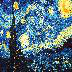

augmented images:


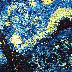

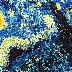

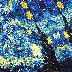

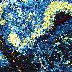

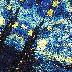

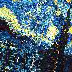

In [5]:
print('original image:')
display(original)

print('augmented images:')
augmented_image = datagen.flow(x, batch_size=1)
for i, img_ in enumerate(augmented_image):
    img_ = next(augmented_image)[0]
    display(array_to_img(img_))
    if i == 5:
        break

### Subset into Train and Test 

In [6]:
train_paintings = all_data[all_data.in_train]
train_paintings.shape

(79433, 12)

In [7]:
test_paintings = all_data[~all_data.in_train]
test_paintings.shape

(23817, 12)

In [8]:
cezanne_vangogh_train = train_paintings[(train_paintings.artist == 'Vincent van Gogh') | (train_paintings.artist == 'Paul Cezanne')]
cezanne_vangogh_train.reset_index(drop=True, inplace=True)
print(cezanne_vangogh_train.shape)
cezanne_vangogh_train.head()

(804, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg
2,Paul Cezanne,1880,genre painting,3176.0,2939.0,1338046.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,True,46247.jpg
3,Paul Cezanne,1880,genre painting,3176.0,2874.0,1146603.0,wikiart,Post-Impressionism,Bathers,train_and_test,True,63504.jpg
4,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg


In [9]:
cezanne_vangogh_train.artist.value_counts()

Paul Cezanne        412
Vincent van Gogh    392
Name: artist, dtype: int64

In [10]:
cezanne_vangogh_test = test_paintings[(test_paintings.artist == 'Vincent van Gogh') | (test_paintings.artist == 'Paul Cezanne')]
cezanne_vangogh_test.reset_index(drop=True, inplace=True)
print(cezanne_vangogh_test.shape)
cezanne_vangogh_test.head()

(189, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Paul Cezanne,1878,genre painting,3176.0,2618.0,1139110.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,False,19446.jpg
1,Paul Cezanne,1894,still life,3176.0,2606.0,737724.0,wikiart,Post-Impressionism,"Curtain, Jug and Fruit",train_and_test,False,94593.jpg
2,Paul Cezanne,1877,symbolic painting,3176.0,2600.0,958500.0,wikiart,Impressionism,The Eternal Woman,train_and_test,False,64480.jpg
3,Paul Cezanne,c.1905,landscape,3176.0,2552.0,836544.0,wikiart,Cubism,Montagne Sainte-Victoire and the Black Chateau,train_and_test,False,71902.jpg
4,Paul Cezanne,c.1890,landscape,3176.0,2551.0,811453.0,wikiart,Post-Impressionism,Mont Sainte-Victoire,train_and_test,False,11113.jpg


In [11]:
cezanne_vangogh_test.artist.value_counts()

Vincent van Gogh    102
Paul Cezanne         87
Name: artist, dtype: int64

### Create directory structure to use with  `.flow_from_directory`
Keras mehod that takes a path to a directory and generates batches of augmented/normalized data... yields batches indefinitely, in an infinite loop

In [12]:
# ####  Training images — Cezanne

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train

# cezanne_file_list = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Paul Cezanne'].new_filename.tolist()
# cezanne_filepath_list = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in cezanne_file_list]

# cezanne_filepath_list[:5]

# for fname in cezanne_filepath_list:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/train/cezanne')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train/cezanne | wc -l

# ####  Training images —  van Gogh 

# vangogh_file_list = cezanne_vangogh_train[cezanne_vangogh_train.artist == 'Vincent van Gogh'].new_filename.tolist()
# vangogh_filepath_list = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in vangogh_file_list]

# vangogh_filepath_list[:5]

# for fname in vangogh_filepath_list:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/train/vangogh')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/train/vangogh | wc -l

# ####  Validation images — Cezanne

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation

# cezanne_file_list_test = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Paul Cezanne'].new_filename.tolist()
# cezanne_filepath_list_test = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in cezanne_file_list_test]

# cezanne_filepath_list_test[:5]

# for fname in cezanne_filepath_list_test:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/validation/cezanne')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation/cezanne | wc -l

# ####  Validation images — van Gogh

# vangogh_file_list_test = cezanne_vangogh_test[cezanne_vangogh_test.artist == 'Vincent van Gogh'].new_filename.tolist()
# vangogh_filepath_list_test = ['../painting_data/kaggle_paint_numbers/resized_72_all/' + fname for fname in vangogh_file_list_test]

# vangogh_filepath_list_test[:5]

# for fname in vangogh_filepath_list_test:
#     shutil.copy(fname, '../painting_data/kaggle_paint_numbers/datagen_modeling/validation/vangogh')

# ! ls ../painting_data/kaggle_paint_numbers/datagen_modeling/validation/vangogh | wc -l

### Load Previously Trained Model

In [13]:
validation_data_dir = '../../data/datagen_modeling/validation/'

img_width, img_height = 72, 72

test = ImageDataGenerator(
    rescale=1./255)

validation_generator = test.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        class_mode='binary')

Found 189 images belonging to 2 classes.


In [14]:
json_file = open('../models/final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
final_model = model_from_json(loaded_model_json)

In [15]:
final_model.load_weights("../models/weights_best.hdf5")

In [16]:
final_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
validation_generator.reset()

In [18]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [19]:
final_model.evaluate_generator(validation_generator, 189, max_q_size=10)

[0.4300231178888021, 0.80423280423280419]

In [20]:
validation_generator.class_indices

{'cezanne': 0, 'vangogh': 1}

In [21]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator):
    if i >= 189:
        break
    pp = final_model.predict_proba(img, verbose=0)
    label = final_model.predict_classes(img, verbose=0)
    predictions.append(pp[0][0])
    predicted_labels.append(label[0][0])

In [22]:
cezanne = glob.glob('../../data/datagen_modeling/validation'+'/cezanne/*.jpg')
vangogh = glob.glob('../../data/datagen_modeling/validation'+'/vangogh/*.jpg')

In [23]:
# 0 = van Gogh, 1 = Cezanne
image_file_predictions = {}

for i, filename in enumerate(cezanne+vangogh):
    image_file_predictions[filename] = {
        'predicted_probability':predictions[i],
        'predicted_label':predicted_labels[i]
    }

In [24]:
predictions_df = pd.DataFrame(image_file_predictions)
predictions_df = predictions_df.T.reset_index()

In [25]:
predictions_df.columns = ['filepath','predicted_label','predicted_probability']
predictions_df['actual_label'] = predictions_df.filepath.map(lambda x: 1 if '/vangogh/' in x else 0)

In [26]:
predictions_df['predicted_artist'] = predictions_df.predicted_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')
predictions_df['true_artist'] = predictions_df.actual_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')

In [27]:
predictions_df.head()

,filepath,predicted_label,predicted_probability,actual_label,predicted_artist,true_artist
0,../../data/datagen_modeling/validation/cezanne...,0.0,0.008516,0,Vincent van Gogh,Vincent van Gogh
1,../../data/datagen_modeling/validation/cezanne...,0.0,0.156942,0,Vincent van Gogh,Vincent van Gogh
2,../../data/datagen_modeling/validation/cezanne...,0.0,0.455940,0,Vincent van Gogh,Vincent van Gogh
3,../../data/datagen_modeling/validation/cezanne...,0.0,0.258495,0,Vincent van Gogh,Vincent van Gogh
4,../../data/datagen_modeling/validation/cezanne...,0.0,0.193313,0,Vincent van Gogh,Vincent van Gogh


In [28]:
predictions_df.predicted_artist.value_counts()

Vincent van Gogh    102
Paul Cezanne         87
Name: predicted_artist, dtype: int64

In [29]:
predictions_df.predicted_label.value_counts()

0.0    102
1.0     87
Name: predicted_label, dtype: int64

In [30]:
predictions_df[predictions_df.predicted_label == predictions_df.actual_label].shape[0] / predictions_df.shape[0]

0.7619047619047619

In [31]:
def conf_matrix_plot(actual, predicted, classes, title=None):

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if not title is None:
        plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', size=14)
    plt.xlabel('Predicted label', size=14)
    plt.show()

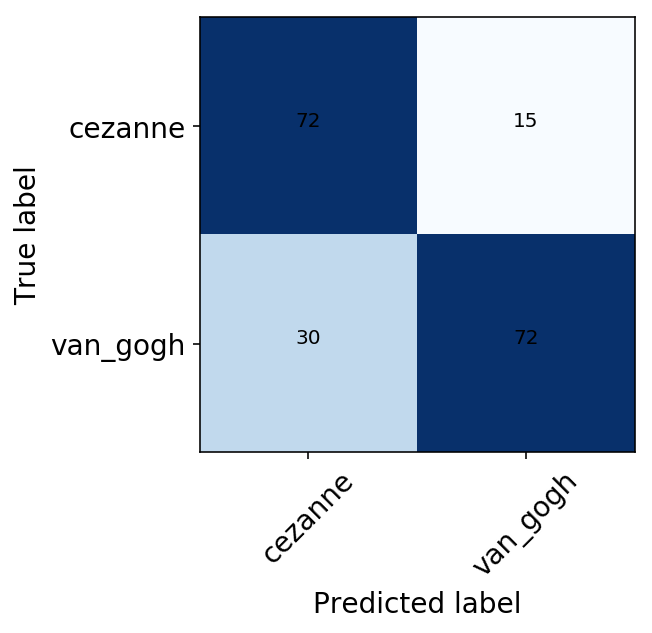

In [32]:
classes = ['cezanne', 'van_gogh']
conf_matrix_plot(predictions_df.actual_label, predictions_df.predicted_label, classes)

In [33]:
print(classification_report(predictions_df['actual_label'], predictions_df['predicted_label']))

             precision    recall  f1-score   support

          0       0.71      0.83      0.76        87
          1       0.83      0.71      0.76       102

avg / total       0.77      0.76      0.76       189



In [34]:
import seaborn as sns

In [35]:
def roc(actual, preds):
    sns.set_style("dark")

    fpr_, tpr_, _ = roc_curve(actual, preds)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(actual)) + 0.5

    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=2,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=2, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('False positive rate', fontsize=14)
    axr.set_ylabel('True positive rate', fontsize=14)
    axr.set_title('Cezanne vs. van Gogh ROC curve\n', fontsize=16)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

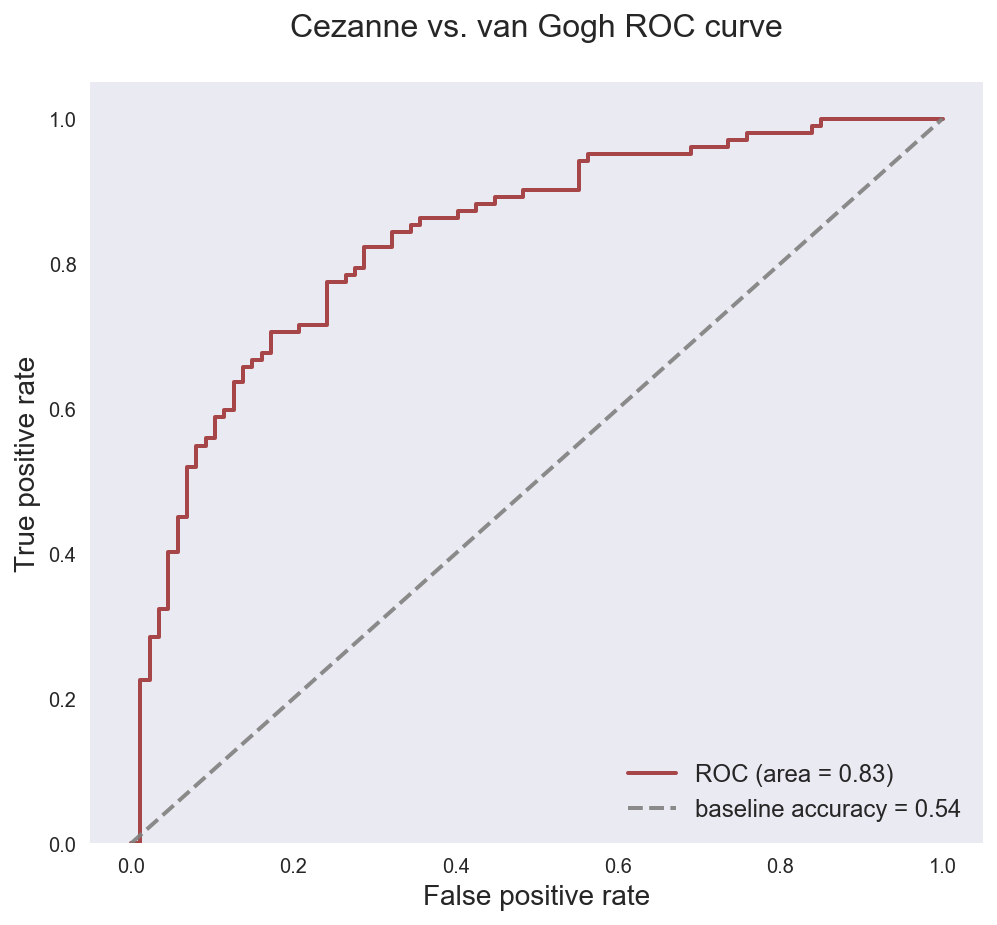

In [36]:
roc(predictions_df['actual_label'], predictions_df['predicted_probability'])

### Error Analysis
To better understand feature learning.

In [37]:
predictions_df.head()

,filepath,predicted_label,predicted_probability,actual_label,predicted_artist,true_artist
0,../../data/datagen_modeling/validation/cezanne...,0.0,0.008516,0,Vincent van Gogh,Vincent van Gogh
1,../../data/datagen_modeling/validation/cezanne...,0.0,0.156942,0,Vincent van Gogh,Vincent van Gogh
2,../../data/datagen_modeling/validation/cezanne...,0.0,0.455940,0,Vincent van Gogh,Vincent van Gogh
3,../../data/datagen_modeling/validation/cezanne...,0.0,0.258495,0,Vincent van Gogh,Vincent van Gogh
4,../../data/datagen_modeling/validation/cezanne...,0.0,0.193313,0,Vincent van Gogh,Vincent van Gogh


In [38]:
correct_mask = predictions_df.predicted_label == predictions_df.actual_label
correct = predictions_df[correct_mask]
top_correct = correct.sort_values(['predicted_probability'], ascending=False)[:5]
top_correct_idx = top_correct.index.values
top_correct_idx_list = top_correct_idx.tolist()

In [74]:
correct_mask_2 = predictions_df.predicted_label == predictions_df.actual_label
correct_2 = predictions_df[correct_mask_2]
top_correct_2 = correct_2.sort_values(['predicted_probability'], ascending=True)[:5]
top_correct_idx_2 = top_correct_2.index.values
top_correct_idx_list_2 = top_correct_idx_2.tolist()

In [39]:
incorrect_mask = predictions_df.predicted_label != predictions_df.actual_label
incorrect = predictions_df[incorrect_mask]
top_incorrect = incorrect.sort_values(['predicted_probability'], ascending=False)[:5]
top_incorrect_idx = top_incorrect.index.values
top_incorrect_idx_list = top_incorrect_idx.tolist()

In [88]:
incorrect_mask_2 = predictions_df.predicted_label != predictions_df.actual_label
incorrect_2 = predictions_df[incorrect_mask_2]
top_incorrect_2 = incorrect_2.sort_values(['predicted_probability'], ascending=True)[:5]
top_incorrect_idx_2 = top_incorrect_2.index.values
top_incorrect_idx_list_2 = top_incorrect_idx_2.tolist()

In [77]:
uncertain_mask = (predictions_df.predicted_probability.between(0.4, 0.6)) & (predictions_df.predicted_label != predictions_df.actual_label)
most_uncertain = predictions_df[uncertain_mask]
top_most_uncertain = most_uncertain.sort_values(['predicted_probability'], ascending=False)[:5]
top_most_uncertain_idx = top_most_uncertain.index.values
top_most_uncertain_idx_list = top_most_uncertain_idx.tolist()

In [78]:
def create_array(subset):
    files = subset.new_filename
    return np.array([img_to_array(load_img('../../data/resized_72_all/' + fname)) for fname in files])

In [79]:
X_test = create_array(cezanne_vangogh_test)

In [82]:
predictions_df['predicted_artist'].head()

0    Vincent van Gogh
1    Vincent van Gogh
2    Vincent van Gogh
3    Vincent van Gogh
4    Vincent van Gogh
Name: predicted_artist, dtype: object

In [83]:
def error_analysis(confidence):
    for i in confidence:
        x = X_test[i]
        x_reshape = x.reshape([72, 72, 3])
        x_display = array_to_img(x_reshape, data_format="channels_last")
        display(x_display)
        print("Prediction: {0} (probability: {1:.2f})\nTrue Label: {2}".format(predictions_df['predicted_artist'][i], 
                                                                               predictions_df['predicted_probability'][i], predictions_df['true_artist'][i]))
        print('------------------------------------------------')

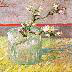

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


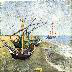

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


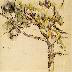

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


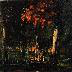

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


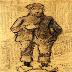

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


In [84]:
error_analysis(top_correct_idx_list)

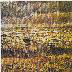

Prediction: Vincent van Gogh (probability: 0.01)
True Label: Vincent van Gogh
------------------------------------------------


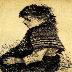

Prediction: Vincent van Gogh (probability: 0.01)
True Label: Vincent van Gogh
------------------------------------------------


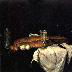

Prediction: Vincent van Gogh (probability: 0.01)
True Label: Vincent van Gogh
------------------------------------------------


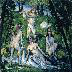

Prediction: Vincent van Gogh (probability: 0.01)
True Label: Vincent van Gogh
------------------------------------------------


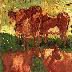

Prediction: Vincent van Gogh (probability: 0.01)
True Label: Vincent van Gogh
------------------------------------------------


In [85]:
error_analysis(top_correct_idx_list_2)

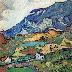

Prediction: Paul Cezanne (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


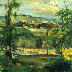

Prediction: Paul Cezanne (probability: 0.97)
True Label: Vincent van Gogh
------------------------------------------------


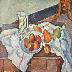

Prediction: Paul Cezanne (probability: 0.94)
True Label: Vincent van Gogh
------------------------------------------------


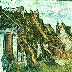

Prediction: Paul Cezanne (probability: 0.94)
True Label: Vincent van Gogh
------------------------------------------------


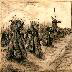

Prediction: Paul Cezanne (probability: 0.90)
True Label: Vincent van Gogh
------------------------------------------------


In [86]:
error_analysis(top_incorrect_idx_list)

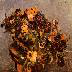

Prediction: Vincent van Gogh (probability: 0.03)
True Label: Paul Cezanne
------------------------------------------------


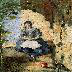

Prediction: Vincent van Gogh (probability: 0.03)
True Label: Paul Cezanne
------------------------------------------------


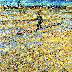

Prediction: Vincent van Gogh (probability: 0.05)
True Label: Paul Cezanne
------------------------------------------------


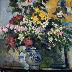

Prediction: Vincent van Gogh (probability: 0.06)
True Label: Paul Cezanne
------------------------------------------------


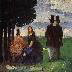

Prediction: Vincent van Gogh (probability: 0.07)
True Label: Paul Cezanne
------------------------------------------------


In [89]:
error_analysis(top_incorrect_idx_list_2)

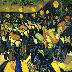

Prediction: Paul Cezanne (probability: 0.58)
True Label: Vincent van Gogh
------------------------------------------------


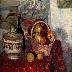

Prediction: Paul Cezanne (probability: 0.56)
True Label: Vincent van Gogh
------------------------------------------------


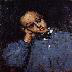

Prediction: Vincent van Gogh (probability: 0.49)
True Label: Paul Cezanne
------------------------------------------------


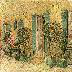

Prediction: Vincent van Gogh (probability: 0.45)
True Label: Paul Cezanne
------------------------------------------------


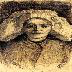

Prediction: Vincent van Gogh (probability: 0.43)
True Label: Paul Cezanne
------------------------------------------------


In [54]:
error_analysis(top_most_uncertain_idx_list)

## Further Testing 

### Canonical but "fake" van Gogh

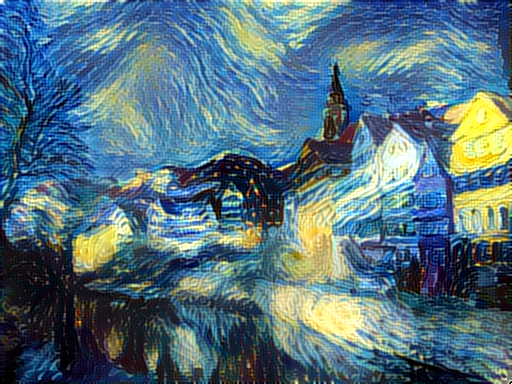

In [63]:
vangogh_style_path = '../../data/demo/vangogh.png'
vangogh_style_img = load_img(vangogh_style_path)
display(vangogh_style_img)

In [64]:
vangogh_style_img = vangogh_style_img.resize((72,72))
vangogh_style_img = img_to_array(vangogh_style_img)*(1./255.)
vangogh_style_img = vangogh_style_img.reshape((1,) + vangogh_style_img.shape)

In [65]:
final_model.predict_classes(vangogh_style_img)

1/1 [==============================] - 0s


array([[1]], dtype=int32)

In [66]:
final_model.predict_proba(vangogh_style_img)

1/1 [==============================] - 0s


array([[ 0.53943336]], dtype=float32)

### Canonical but "fake" Cezanne

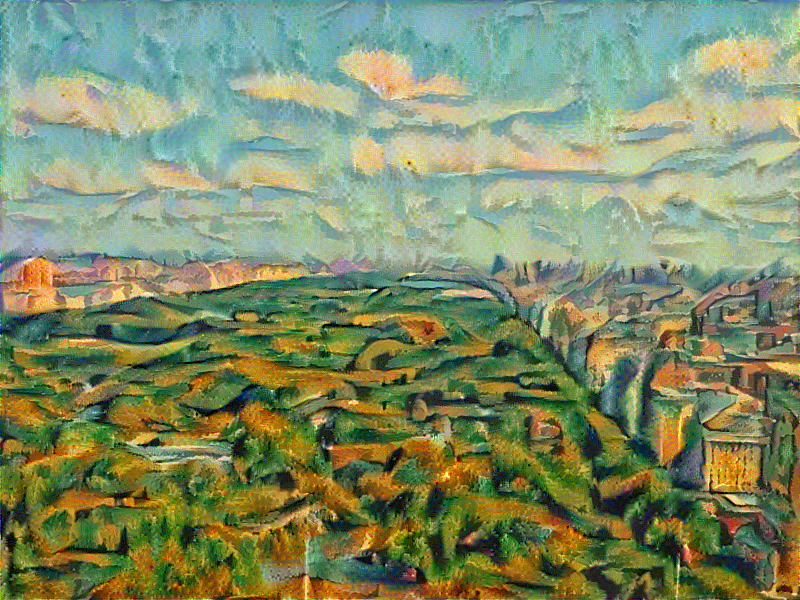

In [69]:
cezanne_style_path = '../../data/demo/cezanne.png'
cezanne_style_img = load_img(cezanne_style_path)
display(cezanne_style_img)

In [70]:
cezanne_style_img = cezanne_style_img.resize((72,72))
cezanne_style_img = img_to_array(cezanne_style_img)*(1./255.)
cezanne_style_img = cezanne_style_img.reshape((1,) + cezanne_style_img.shape)

In [71]:
final_model.predict_classes(cezanne_style_img)

1/1 [==============================] - 0s


array([[0]], dtype=int32)

In [72]:
final_model.predict_proba(cezanne_style_img)

1/1 [==============================] - 0s


array([[ 0.16884562]], dtype=float32)